# NLP for Twitter Sentiment Analysis (Hate Speech/Offensive Lang)

In [3]:

import warnings

import re
from datetime import datetime

import pandas as pd  
import numpy as np


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, concatenate, Activation, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import load_model, Model
from keras.preprocessing.sequence import pad_sequences

from bs4 import BeautifulSoup
from shutil import unpack_archive

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, explained_variance_score, roc_curve

import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, NGram, StringIndexer, Tokenizer, VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Twitter data

### Download and load the data



In [6]:
df=pd.read_csv("twitter-hate-speech-classifier.csv", encoding='latin1')
#f    = open("twitter-hate-speech-classifier.csv","rb")
#df = f.read().decode(errors='replace')

In [7]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,_created_at,orig__golden,orig__last_judgment_at,orig__trusted_judgments,orig__unit_id,orig__unit_state,_updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,0.0,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,1.666196e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,0.0,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.295121e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,0.0,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,NaN,True,NaN,0.0,615562068.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.975147e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate...,0.5185,NaN,True,NaN,0.0,615562488.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,5.889236e+08,@Zhugstubble You heard me bitch but any way I'...


In [8]:
df.shape

(14509, 20)

### EDA

In [9]:
df['_unit_state'].unique()

array(['golden', 'finalized'], dtype=object)

In [10]:
df['_created_at'].unique()

array([nan])

In [11]:
df['orig__golden'].unique()

array([True, nan], dtype=object)

In [12]:
df.drop(['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at','_created_at','orig__unit_id',
         'orig__golden', 'orig__trusted_judgments','orig__last_judgment_at', 'orig__unit_state','_updated_at','does_this_tweet_contain_hate_speech_gold_reason',
        'tweet_id'], axis=1, inplace=True)

In [13]:
df['_unit_id'].nunique()

14509

In [14]:
df.head()

,_unit_id,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speechconfidence,tweet_text
0,853718217,The tweet uses offensive language but not hate...,0.6013,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Warning: penny boards will make you a faggot
1,853718218,The tweet contains hate speech,0.7227,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Fuck dykes
2,853718219,The tweet contains hate speech,0.5229,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,The tweet contains hate speech,0.5184,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,The tweet uses offensive language but not hate...,0.5185,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@Zhugstubble You heard me bitch but any way I'...


In [15]:
df.loc[df['does_this_tweet_contain_hate_speech']!=df['does_this_tweet_contain_hate_speech_gold']]

,_unit_id,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speechconfidence,tweet_text
0,853718217,The tweet uses offensive language but not hate...,0.6013,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Warning: penny boards will make you a faggot
1,853718218,The tweet contains hate speech,0.7227,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Fuck dykes
2,853718219,The tweet contains hate speech,0.5229,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,The tweet contains hate speech,0.5184,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,The tweet uses offensive language but not hate...,0.5185,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@Zhugstubble You heard me bitch but any way I'...
6,853718223,The tweet contains hate speech,0.5207,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,RT @ivanrabago_: @_WhitePonyJr_ looking like f...
7,853718224,The tweet contains hate speech,0.5619,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Well I thought you knew actually RT @KingHorse...
8,853718225,The tweet uses offensive language but not hate...,0.6419,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"@Stonisnipezz I know. It was a joke, faggot."
9,853718226,The tweet uses offensive language but not hate...,0.6407,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,I'm tired of people saying I look like my brot...
10,853718227,The tweet contains hate speech,0.7619,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,#VoteBlue2014 Yeah. CUZ 8 million people in fa...


In [16]:
df['orig_does_this_tweet_contain_hate_speech'].isnull().sum()

14442

In [17]:
df['does_this_tweet_contain_hate_speech_gold'].isnull().sum()

14442

In [18]:
df['does_this_tweet_contain_hate_speech'].unique()

array(['The tweet uses offensive language but not hate speech',
       'The tweet contains hate speech', 'The tweet is not offensive'],
      dtype=object)

In [19]:
df.drop(['orig_does_this_tweet_contain_hate_speech', 'does_this_tweet_contain_hate_speech_gold',
         'does_this_tweet_contain_hate_speechconfidence'], axis=1, inplace=True)

In [20]:
df1=df[['does_this_tweet_contain_hate_speech','tweet_text']]

In [21]:
df1['does_this_tweet_contain_hate_speech']=df1['does_this_tweet_contain_hate_speech'].map({'The tweet is not offensive':0,
                                                'The tweet uses offensive language but not hate speech':1,
                                               'The tweet contains hate speech':2})

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


It looks like both training and test data is sorted by time. Let's shuffle them first:

In [39]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [40]:
df1.columns=["sentiment", 'tweet']

In [41]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [64]:
df1.groupby('sentiment').count()

,tweet
sentiment,
0,7274
1,4836
2,2399


([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([2399. , 2886.5, 3374. , 3861.5, 4349. , 4836.5, 5324. , 5811.5,
        6299. , 6786.5, 7274. ]),
 <a list of 3 Lists of Patches objects>)

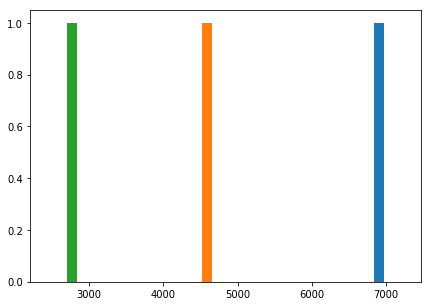

In [90]:
fig, ax = plt.subplots(figsize=(7, 5))
labels=['2399','4836','7274']
#plt.xticks((np.arange(0,3, step=1),labels)
plt.hist(df1.groupby('sentiment').count())
#

### Code clean up



In [25]:
df1["sentiment"] = df1["sentiment"].apply(lambda y: str(y)) 

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [30]:
from sklearn.model_selection import train_test_split
X=df1['tweet']
y=df1['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14218,), (14218,), (291,), (291,))

Let's test the above function on an example with all the patterns that it removes:

Let's save the results so that we can use them in the future, or start from here in future iterations to avoid the huge learning time above.

In [32]:
hate_tweets = "hate_tweets.csv"
df1.to_csv(hate_tweets, index=False, quoting=3, 
                quotechar='', escapechar='\\', encoding='utf-8')

## Logistic Regression w Feature Engineering

In [164]:
import pandas as pd
import numpy as np
import pickle
import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

### Feature generation

In [ ]:
df1['sentiment'].value_counts()

In [191]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    #tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #Convert to lower case, split into individual words:
    tweet= word_tokenize(tweet.lower())
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    #tweet=word_tokenize(tweet.lower())
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [174]:
tweets=df1.tweet
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [210]:
vocab.items()

dict_items([('aap', 0), ('abandon', 1), ('abil', 2), ('abl', 3), ('abort', 4), ('abov', 5), ('absolut', 6), ('abt', 7), ('abus', 8), ('acc', 9), ('accent', 10), ('accept', 11), ('accid', 12), ('accomplish', 13), ('accord', 14), ('account', 15), ('account tri', 16), ('accur', 17), ('accus', 18), ('achiev', 19), ('across', 20), ('across field', 21), ('across field bag', 22), ('act', 23), ('act like', 24), ('act like faggot', 25), ('act like fuck', 26), ('action', 27), ('activ', 28), ('actor', 29), ('actual', 30), ('ad', 31), ('ad video', 32), ('ad video playlist', 33), ('add', 34), ('addict', 35), ('address', 36), ('adel', 37), ('admit', 38), ('adopt', 39), ('ador', 40), ('adult', 41), ('advantag', 42), ('advic', 43), ('af', 44), ('afford', 45), ('afraid', 46), ('africa', 47), ('african', 48), ('age', 49), ('agenc', 50), ('ago', 51), ('agre', 52), ('ah', 53), ('ahead', 54), ('ahh', 55), ('aid', 56), ('aim', 57), ('aint', 58), ('aint makin', 59), ('aint makin nois', 60), ('air', 61), ('ai

In [232]:
#Get POS (parts of speech) tags for tweets and save as a string
#more details https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    #for i in range(0, len(tokens)):
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
        #print(tokens[i],tag_list[i])

C:\Users\user\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [196]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )

In [197]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [219]:
#Now get other features
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [220]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [221]:
feats = get_feature_array(tweets)

In [204]:
tfidf, pos

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [222]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
#M = np.concatenate([tfidf,pos],axis=1)

In [223]:
M.shape

(14509, 8167)

In [224]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
#feature_names = variables+pos_variables

### Running the model
This model was found using a GridSearch with 5-fold cross validation. 

In [225]:
X = pd.DataFrame(M)
y = df1['sentiment'].astype(int)

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [227]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X,y)

In [228]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [229]:
y_preds = model.predict(X_)

In [230]:
report = classification_report( y, y_preds )

In [231]:
print(report)

             precision    recall  f1-score   support

          0       0.92      0.95      0.93      7274
          1       0.76      0.64      0.70      4836
          2       0.52      0.61      0.56      2399

avg / total       0.80      0.79      0.79     14509

